# Exercise 10: Forward modelling of extracellular potentials

In this exercise you will work with forward modelling of extracellular potentials, based on the Hay model (Hay et al. (2011) PLoS Comput Biol 7: e1002107, doi:10.1371/journal.pcbi.1002107). 

You will be given example code below, based on _LFPy_ and _NEURON_, which you can adapt to solve this
exercise.


In [1]:
!nrnivmodl hay_model/mod/

%matplotlib inline
from os.path import join
import numpy as np
import pylab as plt
import neuron
import LFPy
from hay_model.hay_active_declarations import active_declarations
nrn = neuron.h

Creating x86_64 directory for .o files.

/home/tone/work/my_binder_test
ls: klarte ikke å åpne 'hay_model/mod//*.inc': Fila eller mappa finnes ikke
hay_model/mod//CaDynamics_E2.mod hay_model/mod//Ca_HVA.mod hay_model/mod//Ca_LVAst.mod hay_model/mod//Ih.mod hay_model/mod//Im.mod hay_model/mod//K_Pst.mod hay_model/mod//K_Tst.mod hay_model/mod//Nap_Et2.mod hay_model/mod//NaTa_t.mod hay_model/mod//NaTs2_t.mod hay_model/mod//SK_E2.mod hay_model/mod//SKv3_1.mod
CaDynamics_E2.mod Ca_HVA.mod Ca_LVAst.mod Ih.mod Im.mod K_Pst.mod K_Tst.mod Nap_Et2.mod NaTa_t.mod NaTs2_t.mod SK_E2.mod SKv3_1.mod
"/home/tone/progs/neuron/nrn/x86_64/bin/nocmodl" CaDynamics_E2
"/home/tone/progs/neuron/nrn/x86_64/bin/nocmodl" Ca_HVA
"/home/tone/progs/neuron/nrn/x86_64/bin/nocmodl" Ca_LVAst
"/home/tone/progs/neuron/nrn/x86_64/bin/nocmodl" Ih
Translating Ca_LVAst.mod into Ca_LVAst.c
Translating CaDynamics_E2.mod into CaDynamics_E2.c
Translating Ih.mod into Ih.c
Translating Ca_HVA.mod into Ca_HVA.c
Thread Safe
Thread Sa

libtool: link: (cd ".libs" && rm -f "libnrnmech.so.0" && ln -s "libnrnmech.so.0.0.0" "libnrnmech.so.0")
libtool: link: (cd ".libs" && rm -f "libnrnmech.so" && ln -s "libnrnmech.so.0.0.0" "libnrnmech.so")
libtool: link: ( cd ".libs" && rm -f "libnrnmech.la" && ln -s "../libnrnmech.la" "libnrnmech.la" )
Successfully created x86_64/special


Below follows some functions that you can use to solve this exercise. If you would like to understand this code in detail, we recommend reading about the LFPy software: https://lfpy.readthedocs.io 

Summary: A somatic synapse induces a spike in the Hay model that is recorded by
a virtual electrode close to the soma. White noise with a Root-Mean-Square
amplitude of 15 μV has been added to the extracellular signal, to emulate noise in experiental recordings.

In [2]:
def return_cell(conductance_type='active'):
    """
    Returns an LFPy.Cell object that contains the Hay model.
    
    Parameters:
    ===========
    conductance_type: Either 'active' or 'passive'. If 'active' all original ion-channels are included,
           if 'passive' they are all removed, yielding a passive cell model.
    """

    model_path = join('hay_model')
    cell_parameters = {
        'morphology': join(model_path, 'cell1.hoc'),
        'v_init': -65,
        'passive': False,
        'nsegs_method': 'lambda_f',
        'lambda_f': 100,
        'dt': 2**-4,  # Should be a power of 2
        'tstart': -100,
        'tstop': 100,
        'custom_code': [join(model_path, 'custom_codes.hoc')],
        'custom_fun': [active_declarations],
        'custom_fun_args': [{'conductance_type': conductance_type}],
    }
    cell = LFPy.Cell(**cell_parameters)
    return cell


def insert_synapse(cell, synaptic_y_pos=0, weight=0.01, input_spike_train=np.array([20.])):
    """
    Inserts a synapse on the given cell model
    
    Parameters:
    ===========
    cell : LFPy.Cell object that contains the cell model
    synaptic_y_pos: position along the apical dendrite where the synapse is inserted.
    weight: Strength of the synaptic input
    input_spike_train: Numpy array containing synaptic spike times
    """
    synapse_parameters = {
        'idx': cell.get_closest_idx(x=0., y=synaptic_y_pos, z=0.),
        'e': 0.,
        'syntype': 'ExpSyn',
        'tau': 10.,
        'weight': weight,
        'record_current': True,
    }
    synapse = LFPy.Synapse(cell, **synapse_parameters)
    synapse.set_spike_times(input_spike_train)
    return synapse


def make_extracellular_electrode(cell, elec_x=np.array([25.]), elec_y=np.array([0.]), 
                                 elec_z=np.array([0.])):
    """
    Make an extracellular electrode, and calculate the extracellular potential from the given cell
    
    Parameters:
    ===========
    cell : LFPy.Cell object that contains the cell model. This function assumes that the cell simulation is finished
    elec_x, elec_y, elec_z : numpy array with x,y,z position of electrode(s).
    """

    electrode_parameters = {
        'sigma': 0.3,  # extracellular conductivity in S/m
        'x': elec_x,  # x,y,z-coordinates of contact points
        'y': elec_y,
        'z': elec_z,
    }
    electrode = LFPy.RecExtElectrode(cell, **electrode_parameters)
    electrode.calc_lfp()
    return electrode


def plot_electrode_signal(cell, electrode, xlim=[15, 55]):
    """
    Plots the somatic membrane potential and somatic transmembrane currents (left), 
    as well as the cell morphology (center), and the extracellular potential (right).
    
    Parameters:
    ===========
    cell : LFPy.Cell object that contains the cell model. This function assumes that the cell simulation is finished
    electrode: Electrode object from the LFPy class RecExtElectrode 
    """
    cell_plot_idx = 0
    fig = plt.figure(figsize=[12, 9])
    fig.subplots_adjust(hspace=0.5)  # Adjusts the vertical distance between panels.
    ax_cell = fig.add_subplot(132, aspect='equal')
    ax_cell.axis('off')
    
    elec_color = lambda elec_idx: plt.cm.jet(elec_idx / len(electrode.x))
    
    [ax_cell.plot([cell.xstart[idx], cell.xend[idx]], 
              [cell.ystart[idx], cell.yend[idx]], c='k') for idx in range(cell.totnsegs)]
    for idx in range(len(electrode.x)):
        el, = ax_cell.plot(electrode.x[idx], electrode.y[idx], 'D', c=elec_color(idx), ms=14)
    syn, = ax_cell.plot(cell.xmid[cell.synidx], cell.ymid[cell.synidx], '*', c='g', ms=14)
    
    ax_cell.legend([el, syn], ["Electrode", "Synapse"], frameon=False, loc="lower center")
    
    ax_v = fig.add_subplot(231, title='Somatic\nmembrane potential', xlim=xlim,
                           xlabel='Time [ms]', ylabel='mV')
    ax_v.plot(cell.tvec, cell.vmem[cell_plot_idx, :], color='k', lw=2)
    
    ax_i = fig.add_subplot(234, title='Somatic\ntransmembrane currents',  xlim=xlim,
                           xlabel='Time [ms]', ylabel='nA')
    ax_i.plot(cell.tvec, cell.imem[cell_plot_idx, :], color='k', lw=2)

    np.random.seed(1234)
    #  Make signal with units uV (instead of mV) and add normally distributed white noise with RMS of 15
    signal_with_noise = 1000 * electrode.LFP + np.random.normal(0, 15, size=electrode.LFP.shape)
    ylim = np.max(np.abs(signal_with_noise)) * 1.2
    ax_ec = fig.add_subplot(133, title='Extracellular potential', xlim=xlim,
                            xlabel='Time [ms]', ylabel='$\mu V$', ylim=[-ylim, ylim])
    [ax_ec.plot(cell.tvec, signal_with_noise[idx, :], c=elec_color(idx), lw=2) for idx in range(len(electrode.x))]
    
    from plotting_convention import simplify_axes
    simplify_axes([ax_v, ax_i, ax_ec])

## Task 1
Given a noise level on the virtual extracellular electrode corresponding to
white noise with a Root-Mean-Square of 15 μV, roughly how far away from soma
will a spike from the Hay model be visible on an electrode?

_Note_: The soma of the cell is in origo, and you can change the distance to the electrode by for example changing the _x_ position of the electrode (elec_x)

active ion-channels inserted.


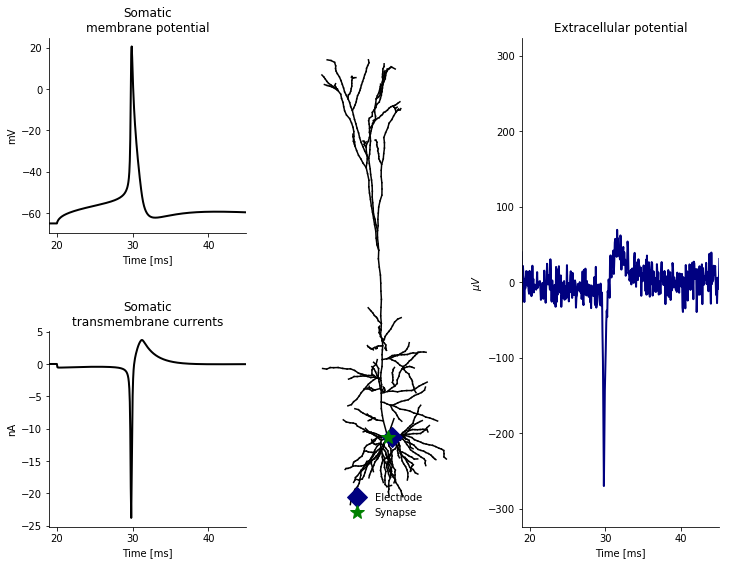

In [3]:
cell = return_cell(conductance_type="active")
insert_synapse(cell, synaptic_y_pos=0, weight=0.01)
cell.simulate(rec_imem=True, rec_vmem=True)
elec_x = np.array([15.,])
elec_y = np.array([0.0,])
elec_z = np.array([0.0,])
electrode = make_extracellular_electrode(cell, elec_x, elec_y, elec_z)
plot_electrode_signal(cell, electrode, xlim=[19, 45])

## Taks 2:
We will now look at the origin of the Local Field Potential (LFP), which
is typically assumed to be caused by synaptic input to large populations of cells.

Decrease the synaptic weight so that the cell does not fire an action potential, and
plot the extracellular amplitude on a dense 2D grid around the cell at the time
corresponding to the maximum deflection in the membrane potential at the position of the synapse. A
plotting function for this is already implemented below. 

* What shape does the LFP around the cell have for a somatic synapse (y=0)? 

* What shape does the LFP around the cell have for a synapse arriving at the center of the apical dendrite
of the cell (y = 600 μm)? How about at the distal apical dendrite (y = 1200 μm)?

* Can you, based only on the shape of the LFP, predict which of the three that will
fall of most rapid with distance from the cell? _Hint: Distance decay of a dipole versus higher order multipoles._

In [ ]:
def dense_2D_LFP(cell):

    #  Make dense 2D grid of electrodes
    x = np.linspace(-1000, 1000, 26)
    y = np.linspace(-500, 1500, 26)
    x, y = np.meshgrid(x, y)
    elec_x = x.flatten()
    elec_y = y.flatten()
    elec_z = np.zeros(len(elec_x))

    electrode_parameters = {
    'sigma': 0.3,  # extracellular conductivity in S/m
    'x': elec_x,  # x,y,z-coordinates of contact points
    'y': elec_y,
    'z': elec_z,
    }
    electrode = LFPy.RecExtElectrode(cell, **electrode_parameters)
    electrode.calc_lfp()

    fig = plt.figure(figsize=[12, 12])
    ax = fig.add_subplot(111, aspect=1, frameon=False, xlabel="x ($\mu$m)", ylabel="y ($\mu$m)")
    [ax.plot([cell.xstart[idx], cell.xend[idx]], 
        [cell.ystart[idx], cell.yend[idx]], c='k') for idx in range(cell.totnsegs)]
    
    syn, = ax.plot(cell.xmid[cell.synidx], cell.ymid[cell.synidx], '*', c='g', ms=14)
    
    ax.legend([syn], ["Synapse"], frameon=False, loc="lower right")
    time_idx = np.argmax(cell.vmem[cell.synidx, :])
    sig_amp = 1000 * electrode.LFP[:, time_idx].reshape(x.shape)
    color_lim = np.max(np.abs(sig_amp))/5
    img = ax.imshow(sig_amp, origin='lower', extent=[np.min(x), np.max(x), np.min(y), np.max(y)],
               vmin=-color_lim, vmax=color_lim, interpolation='nearest', cmap=plt.cm.bwr)
    plt.colorbar(img, ax=ax, label="$\mu$V")

In [ ]:
cell = return_cell(conductance_type="active")
insert_synapse(cell, synaptic_y_pos=0, weight=0.001)
cell.simulate(rec_imem=True, rec_vmem=True)
dense_2D_LFP(cell)

## Task 3
Compare the LFP from this pyramidal cell model, with the LFP from the interneuron cell model
from Exercise 6 (code below). Are there differences that might be important? 

_Hint: The LFP is expected to result from many synaptic inputs to many different cells, and the LFP is not expected to sum in the same way for these two different cell types_.

Based on the results from Task 2 and Task 3 in this exercise, it is possible to make quite strong claims about which neuronal processes that will dominate the LFP. For more information on this, see:
Lindén et al. (2010) Intrinsic dendritic filtering gives low-pass power spectra of local field potentials. J Comput Neurosci 29: 423–444. http://www.ncbi.nlm.nih.gov/pubmed/20502952

In [ ]:
def return_IN_cell():
    """
    Returns an LFPy.Cell object that contains a passive interneuron model.
    """

    cell_parameters = {
        'morphology': join('IN.hoc'),
        'v_init': -65,
        'passive': True,
        'nsegs_method': 'lambda_f',
        'lambda_f': 100,
        'dt': 2**-4,  # Should be a power of 2
        'tstart': -100,
        'tstop': 100,
    }
    cell = LFPy.Cell(**cell_parameters)
    return cell

In [ ]:
cell = return_IN_cell()
insert_synapse(cell, synaptic_y_pos=-250, weight=0.001)
cell.simulate(rec_imem=True, rec_vmem=True)
dense_2D_LFP(cell)